# protostars
## 08- `Star_BB.py` experiment 3
### I. Run01

Re-run `Starfish` with the `Star_BB.py` code with the solid angle adjustment.

In [1]:
import pandas as pd

In [2]:
ws = np.load("../sf/exp3/output/bb_absolute/run01/emcee_chain.npy")

This took 194 minutes:

In [3]:
194.0/60

3.2333333333333334

Not bad!

In [4]:
burned = ws[:, -1000:,:]
xs, ys, zs = burned.shape
fc = burned.reshape(xs*ys, zs)
nx, ny = fc.shape

In [5]:
from matplotlib.ticker import MaxNLocator

In [6]:
label = [r"$T_{\mathrm{eff}}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$",r"$v_z$", r"$v\sin{i}$", r"$\log{\Omega}$", 
         r"$T_{\mathrm{BB}}$", r"$\log{\Omega_2}$", r"$c^1$", r"$c^2$", r"$c^3$", r"sigAmp", r"logAmp", r"$l$"] 

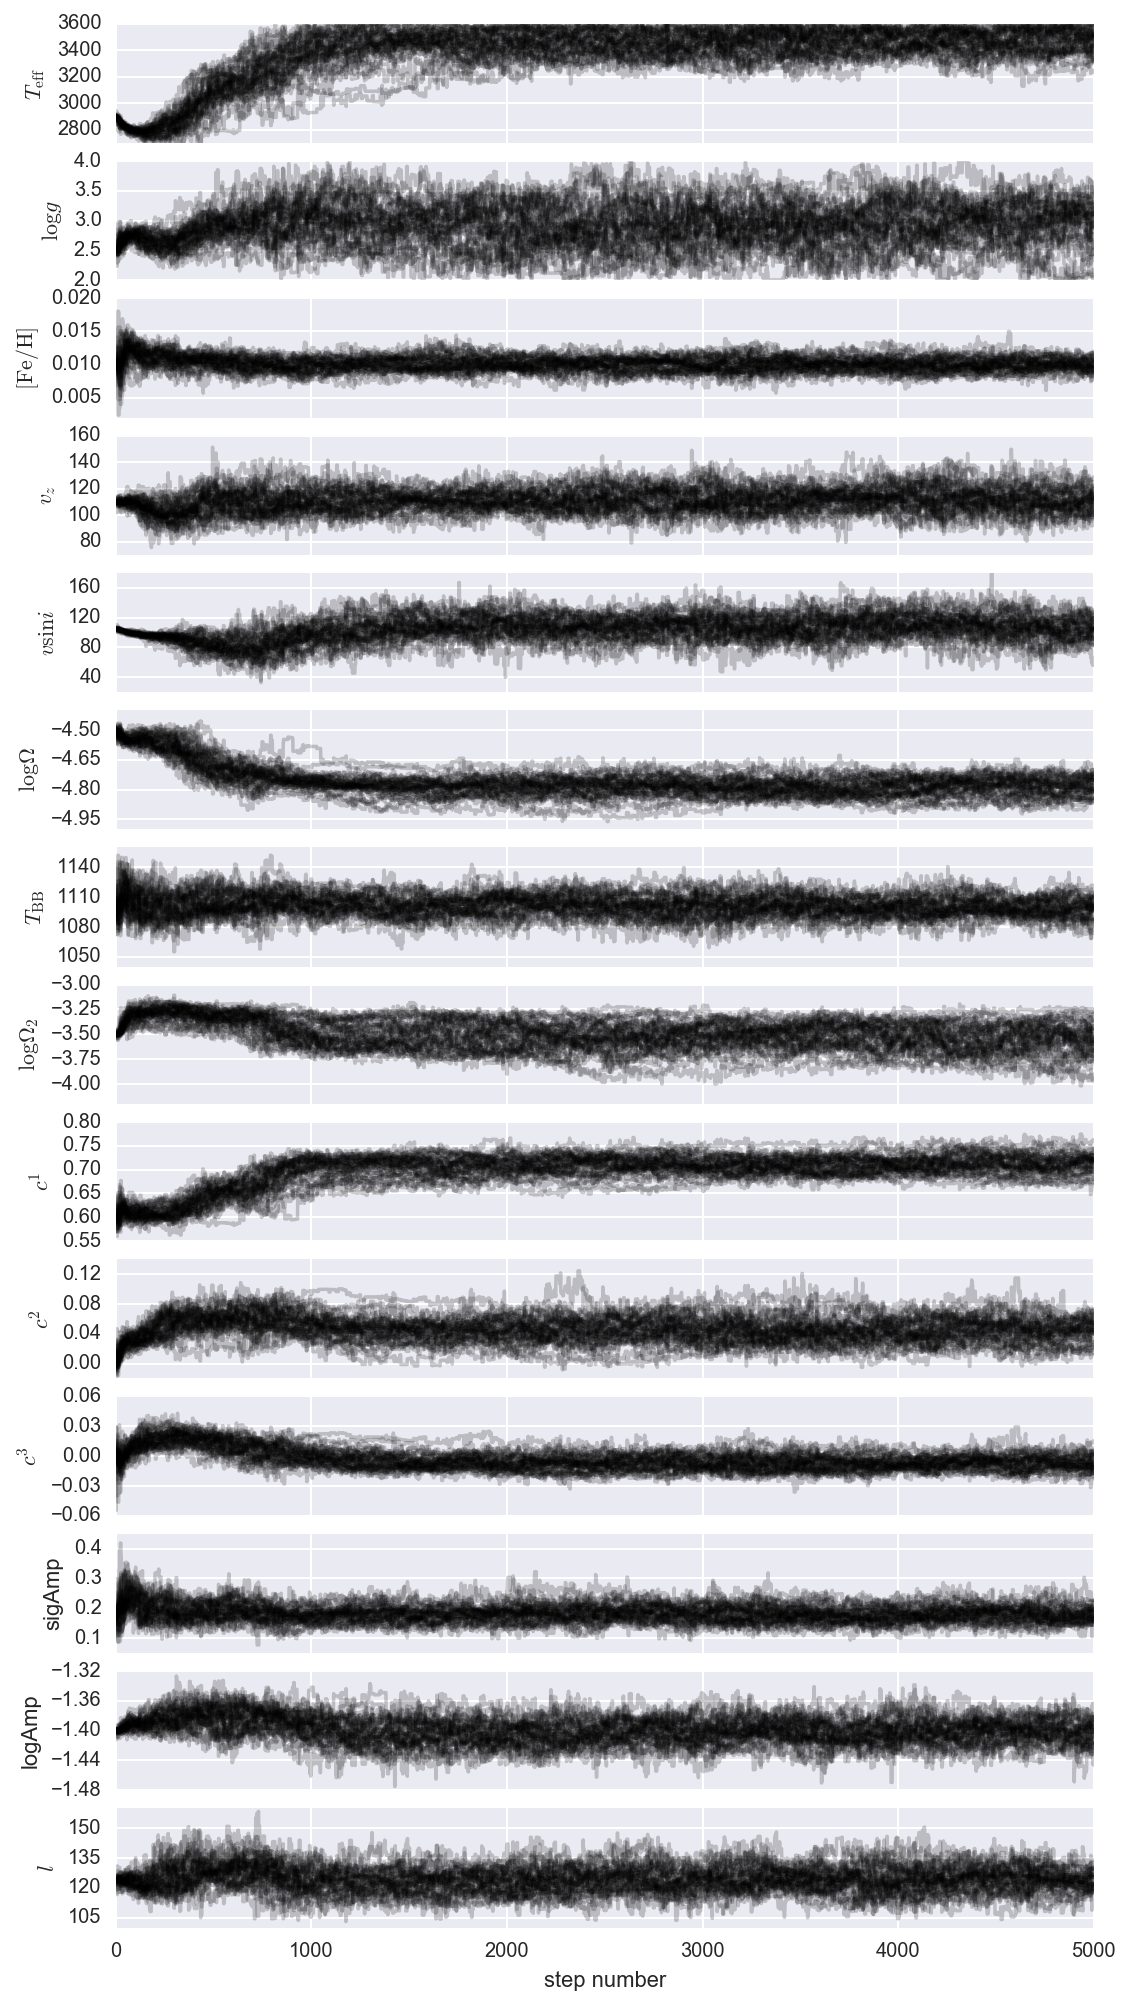

In [7]:
fig, axes = plt.subplots(14, 1, sharex=True, figsize=(8, 14))
for i in range(0, 14, 1):
    axes[i].plot(ws[:, :, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(label[i])

axes[13].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)

It looks like the chains are mixed and sufficiently burned in based on a fairly unscientific by-eye check.

In [8]:
ws.shape

(40, 5000, 14)

In [9]:
fc.shape

(40000, 14)

In [10]:
np_labs = np.array(label)

In [11]:
np_labs[0:8]

array(['$T_{\\mathrm{eff}}$', '$\\log{g}$', '$[\\mathrm{Fe}/\\mathrm{H}]$',
       '$v_z$', '$v\\sin{i}$', '$\\log{\\Omega}$', '$T_{\\mathrm{BB}}$',
       '$\\log{\\Omega_2}$'], 
      dtype='<U26')

In [12]:
import corner
fig = corner.corner(fc[:,0:8], labels=np.array(label)[0:8])
fig.savefig('../plots/exp3_run01_corner.png', dpi=300)

These are the results on the astrophysical parameters.

## Spectroscopy

In [13]:
draws = pd.read_csv('../sf/exp1/output/veil1/run01/models_ff-05_50_95.csv')

In [14]:
sns.set_context('notebook')

In [15]:
raw_mods = np.load('../sf/exp3/output/bb_absolute/run01/raw_models.npy', mmap_mode='r')

`emcee` is smart enough to double count the metadata blobs!!  Awesome!

In [16]:
#raw_mods[4808, 35, 0, :] - raw_mods[4807, 35, 0, :] #all zeros! :)

In [17]:
raw_mods.shape

(5000, 40, 4, 936)

In [18]:
i=4900
star, disk, cheb, flux_mean = raw_mods[i,0,0,:], raw_mods[i,0,1,:], raw_mods[i,0,2,:], raw_mods[i,0,3,:]

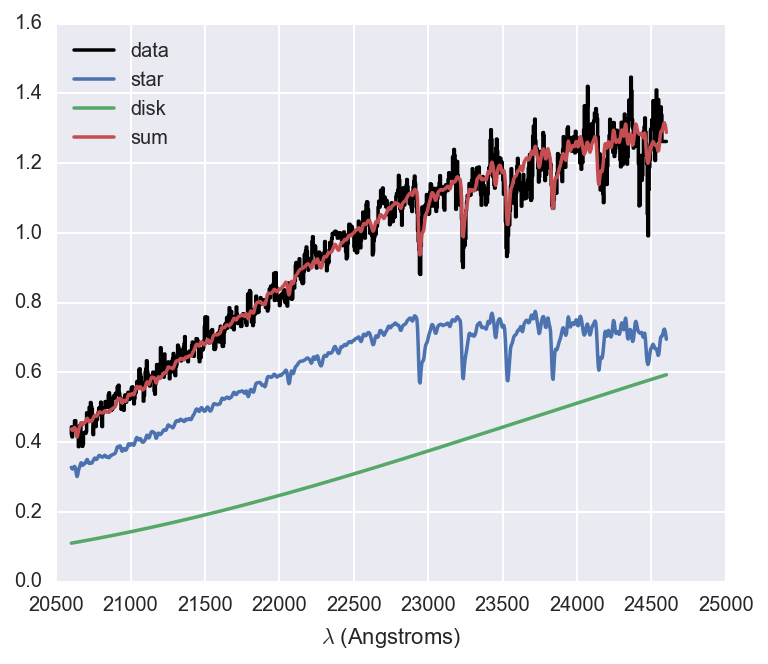

In [19]:
plt.figure(figsize=(6, 5))
plt.step(draws.wl, draws.data, 'k')
plt.plot(draws.wl, star, label = 'star')
plt.plot(draws.wl, disk, label = 'disk')
plt.plot(draws.wl, star+disk, label = 'sum')
plt.xlabel('$\lambda$ (Angstroms)')
#plt.ylim(0,1.6)
plt.legend(loc='best')

### Divided by scaling

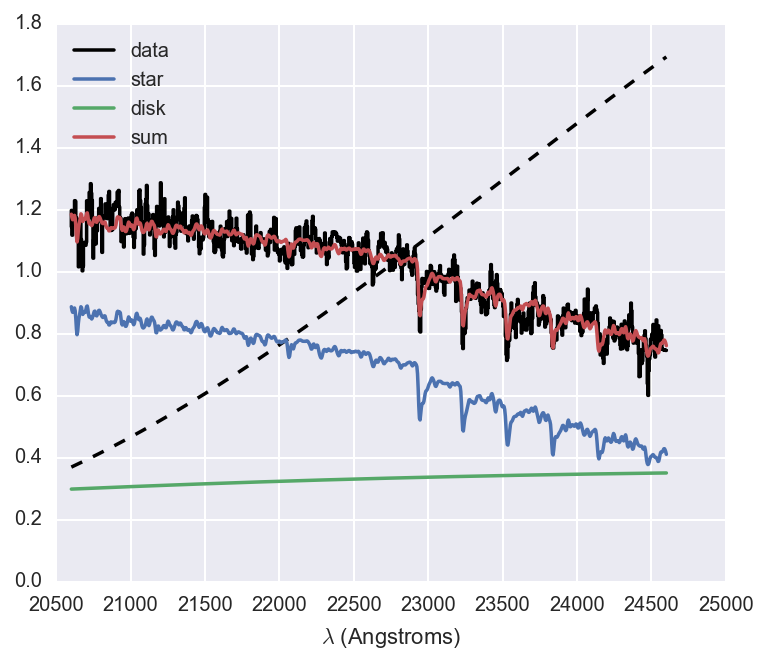

In [20]:
plt.figure(figsize=(6, 5))
plt.plot(draws.wl, cheb, 'k--')
plt.step(draws.wl, draws.data/cheb, 'k')
plt.plot(draws.wl, star/cheb, label = 'star')
plt.plot(draws.wl, disk/cheb, label = 'disk')
plt.plot(draws.wl, star/cheb+disk/cheb, label = 'sum')
plt.xlabel('$\lambda$ (Angstroms)')
plt.ylim(0,1.8)
plt.legend(loc='best')

## Compute the average veiling
$r_\lambda \equiv f_{exc} / f_\star$ is well-defined.  
$r_K$ is not well-defined.  Is it $r_\lambda$ evaluated in $K-$band?  Where in $K-$band?  Is it integrated over the filter curve?   
For the purposes of this paper, I will simply take $r_K=$ the median value of $r_\lambda$

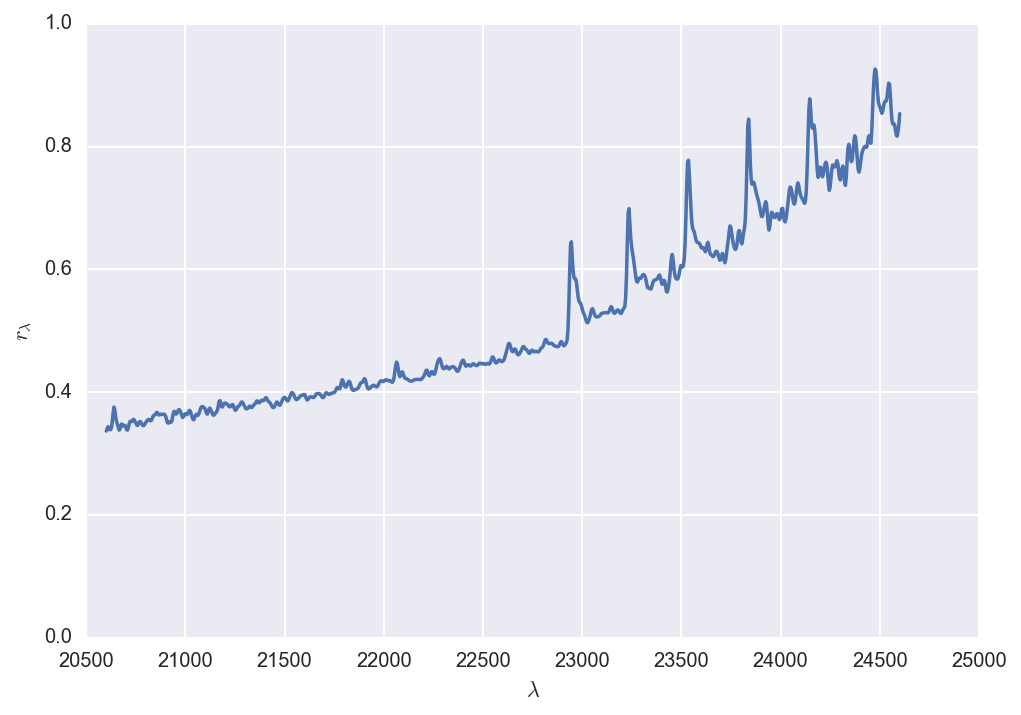

In [21]:
plt.plot(draws.wl, disk/star)
plt.ylim(0)
plt.ylabel('$r_\lambda$')
plt.xlabel('$\lambda$')

In [22]:
r_K = np.median(disk/star)
r_K

memmap(0.4556373886236519)

/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


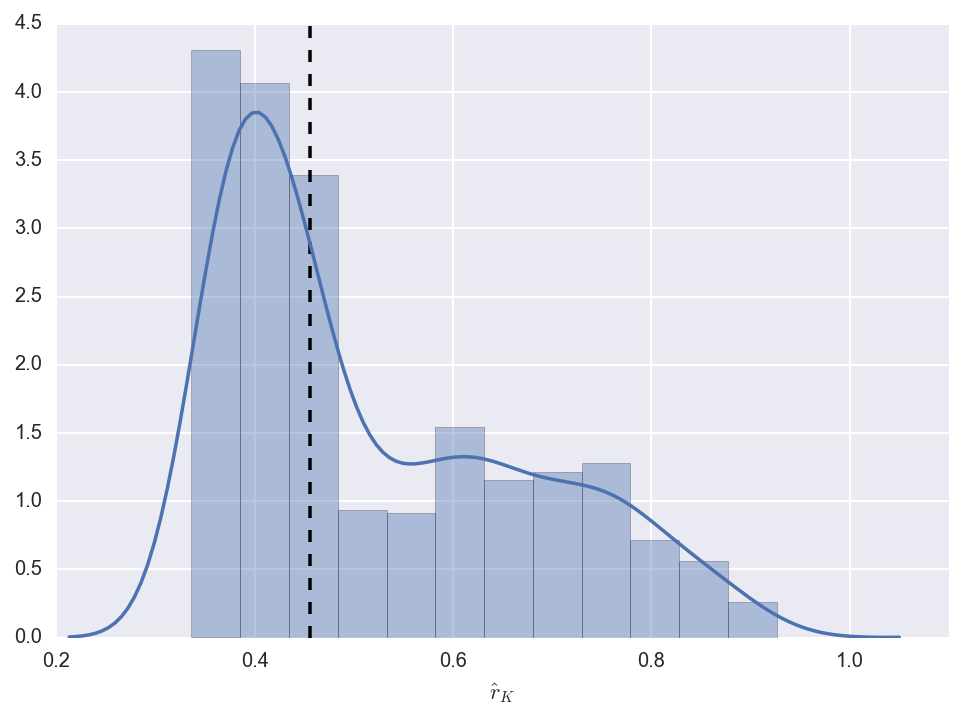

In [23]:
sns.distplot(disk/star)
plt.vlines(r_K, 0, 4.5, linestyles='dashed')
plt.xlabel('$\hat r_K$')

Seems legit, albeit heuristic.  
So now we just have to compute this value over the entire `raw_models` and then save the output.

In [24]:
r_K_all = np.median(raw_mods[-1000:,:,1,:]/raw_mods[-1000:,:,0,:], axis=2)

In [25]:
r_K_all_flat = r_K_all.reshape(1000*40)

/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


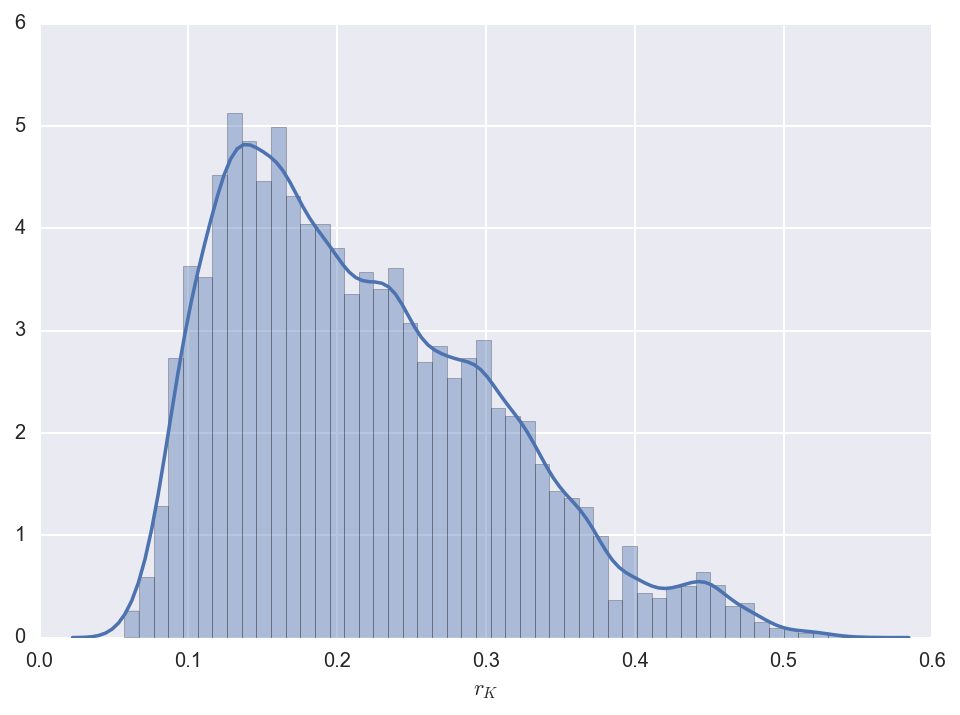

In [26]:
sns.distplot(r_K_all_flat)
plt.xlabel('$r_K$')

## Solid angle ratio is a better, more physical metric.

Compute the ratio of solid angles of disk to star:  
## $\frac{\Omega_d}{\Omega_\star} = \frac{r_d^2 d^2}{r_\star^2 d^2} = \frac{r_d^2}{r_\star^2}$  
(with geometrical assumptions).  
This is really the flux-weighted solid angle at an average wavelength in $K$-band.

In [27]:
om_ratio = 10**fc[:, 7]/10**fc[:, 5]

In [28]:
om_ratio

array([ 41.46581813,  41.46581813,  41.46581813, ...,   5.59672054,
         5.59672054,   5.59672054])

In [29]:
sns.set_context('paper',font_scale=1.8)

In [30]:
sns.set_style('ticks')

/anaconda/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


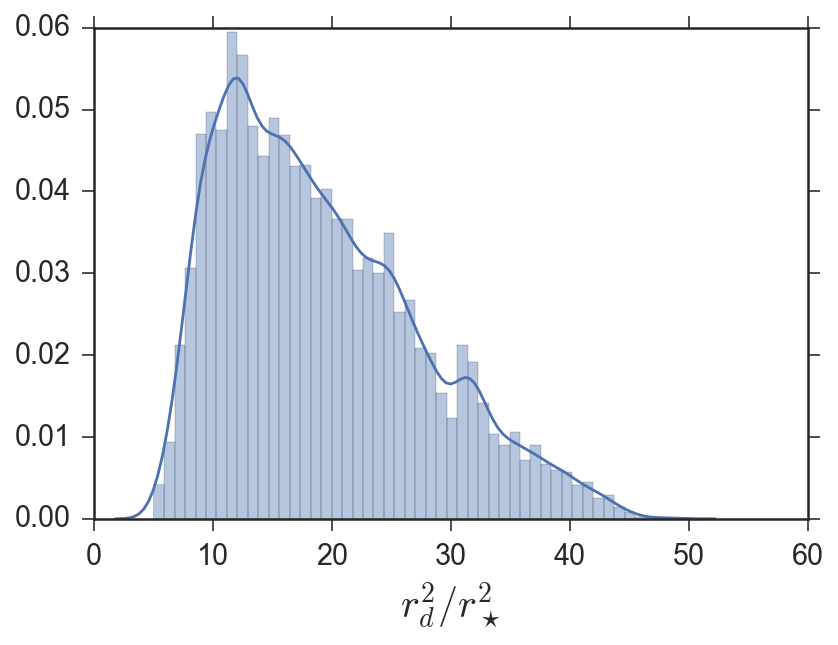

In [31]:
sns.distplot(om_ratio)
plt.xlabel(r'$r_d^2/r_\star^2$', fontsize=20)

In [32]:
plt.figure(figsize=(5,5))
sns.kdeplot(om_ratio, fc[:,1], shade=True, shade_lowest=False)
plt.xlabel(r'$r_d^2/r_\star^2$', fontsize=20)
plt.ylabel(r'$\log{g}$', fontsize=20)
plt.savefig('../plots/logg_omega.pdf', bbox_inches='tight')

$g = GM/r_\star^2$

In [33]:
import astropy.units as u

In [34]:
import astropy.constants as C

In [35]:
rs = np.arange(1.0, 10.0, 0.1)*u.R_sun

y_vals = (C.G*0.5*u.M_sun/(1.0*rs)**2).to(u.cm/u.s**2).value
x_vals_raw = (0.01*u.AU)**2/((1.0*rs)**2)
x_vals = x_vals_raw.to(u.dimensionless_unscaled)

In [36]:
plt.figure(figsize=(5,5))
sns.kdeplot(om_ratio, 10**fc[:,1], shade=True, shade_lowest=False)
plt.xlabel(r'$r_d^2/r_\star^2$', fontsize=20)
plt.ylabel(r'$g$ (cm/s$^2$)', fontsize=20)
plt.yscale('log')
plt.ylim(10**2.0, 10**4.0)
plt.xlim(0.0, 50.0)

convs = {(0,0):'k-',
         (0,1):'k:',
         (1,0):'r-',
         (1,1):'r:'}

for i, ms in enumerate([0.25, 0.5]):
    for j, r_d in enumerate([0.05, 0.10]):
        y_vals = (C.G*1.0*ms*u.M_sun/(1.0*rs)**2).to(u.cm/u.s**2).value
        x_vals_raw = (r_d*u.AU)**2/((1.0*rs)**2)
        x_vals = x_vals_raw.to(u.dimensionless_unscaled)
        plt.plot(x_vals, y_vals, convs[(i,j)],
                 label="{:.1f} $M_\odot$, {:.2f} AU".format(ms, r_d))
        
plt.legend(loc='best', ncol=2, fontsize=9)
plt.savefig('../plots/logg_omega_phys.pdf', bbox_inches='tight')

The end.